# Skracające sztuczne sieci neuronowe

Urszula Kicinger, Bartłomiej Wiśniewski


## **Cel projektu**

Celem projektu była implementacja sieci neuronowej, która generuje hash dla danego obrazu. Zaimplementowana sieć była trenowana na zbiorze zdjęć psów - Stanford Dogs (https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset).

## Import potrzebnych bibliootek

In [75]:
%pip install opencv-python tqdm

In [76]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, Subset
from torch import nn
from cv2 import imread
import matplotlib.pyplot as plt
import io

import random

In [77]:
import warnings
warnings.filterwarnings("ignore")

In [78]:
import xml.etree.ElementTree as ET
import tqdm

In [79]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Przygotowanie zbioru danych

In [80]:
def crop_image(image, bndbox):
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    return image[ymin:ymax, xmin:xmax]


class StanfordDogsDataset(Dataset):
    def __init__(self, root_dir, limit_classes=10000, limit_img_per_class=10000, transform=None):
        self.root_dir = root_dir
        self.img_names = []
        self.bndx = []
        self.breed = []
        self.label_to_idx = dict()
        self.transform = transform

        annotations_dir = os.path.join(self.root_dir, 'annotations', 'Annotation')
        images_dir = os.path.join(self.root_dir, 'images', 'Images')

        annotations = os.listdir(annotations_dir)
        for _, annotation_dir_name in zip(range(limit_classes), annotations):
            category_img_dir = os.path.join(images_dir, annotation_dir_name)
            annotation_dir = os.path.join(annotations_dir, annotation_dir_name)
            images_names = os.listdir(category_img_dir)

            for _, image_name in zip(range(limit_img_per_class), images_names):
                ann = ET.parse(os.path.join(annotation_dir, image_name.split('.')[0])).getroot()
                obj = ann.find('object')
                name = obj.find('name').text
                bndbox = obj.find('bndbox')

                if name not in self.label_to_idx:
                    self.label_to_idx[name] = len(self.label_to_idx)


                self.img_names.append(os.path.join(category_img_dir, image_name))
                self.bndx.append(bndbox)
                self.breed.append(name)


    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ann = self.breed[idx]
        bndbox = self.bndx[idx]

        img = imread(self.img_names[idx])
        img = crop_image(img, bndbox)


        if self.transform:
            img = self.transform(img)

        return img.to(torch.float), self.label_to_idx[ann]

## Stworzenie modelu sieci CNN

In [81]:
# CNN model
class HashingNet(torch.nn.Module):
    def __init__(self, encoding_size):
        super().__init__()
        self.encoding_size = encoding_size
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 3, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(1, 3),
            torch.nn.Linear(6272, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, encoding_size),
            torch.nn.Sigmoid(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(encoding_size, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 6272),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (128,7,7)),

            torch.nn.ConvTranspose2d(128, 64, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Upsample(size=(31,31)),

            torch.nn.ConvTranspose2d(64, 32, 3, 2),
            torch.nn.ReLU(),

            torch.nn.Upsample(size=(127,127)),

            torch.nn.ConvTranspose2d(32, 3, 3, 2),
            torch.nn.Upsample(size=(512,512)),

            torch.nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        if self.training:
            decoded = self.decoder(encoded)
            return decoded
        return encoded


class Classifier(torch.nn.Module):
    def __init__(self, encoding_size=1024, classes=10):
        super().__init__()
        self.pool = torch.nn.MaxPool2d(2)
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten(1, 3)
        self.sigmoid = torch.nn.Sigmoid()

        self.conv1 = torch.nn.Conv2d(3, 32, 3, 2)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 2)
        self.conv3 = torch.nn.Conv2d(64, 128, 3, 2)
        self.fc1 = torch.nn.Linear(6272, 2048)
        self.fc2 = torch.nn.Linear(2048, encoding_size)

        self.last = torch.nn.Linear(encoding_size, classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        x = self.last(x)

        return x

def accuracy_test(model, loader):
    model.eval()
    correct = 0
    total = 0

    subset = torch.utils.data.Subset(loader.dataset, random.sample(range(len(loader.dataset)), 200))
    with torch.no_grad():
        for data in torch.utils.data.DataLoader(subset):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total


def train_classifier(model, train_loader, optimizer, epochs=5):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(tqdm.tqdm(train_loader), 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 50 == 49:
                acc = accuracy_test(model, train_loader)
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 1000}, accuracy: {acc}')
        acc = accuracy_test(model, train_loader)
        print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 1000}, accuracy: {acc}')


def train_autoencoder(model, train_loader, optimizer, epochs=5):
    model.train()
    criterion = torch.nn.L1Loss()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(tqdm.tqdm(train_loader), 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 1000}')


In [82]:
def transpose_conv_layer(conv_layer):
    """
    Transpose a pretrained Conv2d layer into a ConvTranspose2d layer.

    Args:
        conv_layer (nn.Conv2d): The pretrained Conv2d layer to transpose.

    Returns:
        nn.ConvTranspose2d: The transposed Conv2d layer as a ConvTranspose2d layer.
    """
    if not isinstance(conv_layer, nn.Conv2d):
        raise TypeError("The provided layer must be an instance of nn.Conv2d")

    # Extract weights and biases
    weights = conv_layer.weight
    biases = conv_layer.bias

    # Initialize a ConvTranspose2d layer
    conv_transpose = nn.ConvTranspose2d(
        in_channels=conv_layer.out_channels,
        out_channels=conv_layer.in_channels,
        kernel_size=conv_layer.kernel_size,
        stride=conv_layer.stride,
        padding=conv_layer.padding,
        output_padding=conv_layer.output_padding if hasattr(conv_layer, 'output_padding') else 0
    )
    conv_transpose.weight.data = conv_transpose.weight.data.to(device)
    conv_transpose.bias.data = conv_transpose.bias.data.to(device)

    # Copy weights and biases into the ConvTranspose2d layer
    # conv_transpose.weight.data = weights.data.T.contiguous()
    conv_transpose.weight.data = weights.data.clone()
    return conv_transpose



def copy_weights_from_classifier(classifier, hashing_net):
    with torch.no_grad():
        # Copy encoder weights
        hashing_net.encoder[0].weight.copy_(classifier.conv1.weight)
        hashing_net.encoder[0].bias.copy_(classifier.conv1.bias)

        hashing_net.encoder[3].weight.copy_(classifier.conv2.weight)
        hashing_net.encoder[3].bias.copy_(classifier.conv2.bias)

        hashing_net.encoder[6].weight.copy_(classifier.conv3.weight)
        hashing_net.encoder[6].bias.copy_(classifier.conv3.bias)

        hashing_net.encoder[10].weight.copy_(classifier.fc1.weight)
        hashing_net.encoder[10].bias.copy_(classifier.fc1.bias)

        hashing_net.encoder[12].weight.copy_(classifier.fc2.weight)
        hashing_net.encoder[12].bias.copy_(classifier.fc2.bias)

        # Copy decoder weights (transposed from encoder weights)
        hashing_net.decoder[0].weight.copy_(classifier.fc2.weight.T)
        hashing_net.decoder[2].weight.copy_(classifier.fc1.weight.T)
        hashing_net.decoder[5] = transpose_conv_layer(classifier.conv3)
        hashing_net.decoder[8] = transpose_conv_layer(classifier.conv2)
        hashing_net.decoder[11] = transpose_conv_layer(classifier.conv1)


def compare(encoder, dataset, i1, i2):
    # get 2 random images and their label
    encoder.eval()
    img1, lab1 = dataset[i1]
    img2, lab2 = dataset[i2]

    # forward pass on 2 images
    output1 = encoder(img1.unsqueeze(0).to(device))
    output2 = encoder(img2.unsqueeze(0).to(device))


    # calculate cosine similarity
    cos = torch.nn.CosineSimilarity(dim=1)

    return lab1 == lab2, cos(output1, output2)

## Trening modelu 1 (hash length: 64)

In [83]:
from google.colab import drive
drive.mount('/content/drive')
# dataset_path =

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512))
])

trainset = StanfordDogsDataset(dataset_path, limit_classes=10, limit_img_per_class=200, transform=data_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

In [85]:
print("train dataset size:", len(trainset))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

encoding_size = 64
classifier = Classifier(encoding_size=encoding_size, classes=10).to(device)
hashNet = HashingNet(encoding_size=encoding_size).to(device)

cl_opt = torch.optim.Adam(classifier.parameters(), lr=0.001)

train dataset size: 1814


In [86]:
train_classifier(classifier, train_loader, cl_opt, epochs=6)

100%|██████████| 15/15 [00:40<00:00,  2.71s/it]


[1, 15] loss: 0.03450814032554626, accuracy: 0.11


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


[2, 15] loss: 0.03304196405410766, accuracy: 0.275


100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


[3, 15] loss: 0.03060765504837036, accuracy: 0.3


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


[4, 15] loss: 0.02902663004398346, accuracy: 0.335


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


[5, 15] loss: 0.028159446954727173, accuracy: 0.425


100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


[6, 15] loss: 0.02729435217380524, accuracy: 0.395


## Fine-tuning modelu 1

In [87]:
copy_weights_from_classifier(classifier, hashNet)

In [88]:
optimizer = torch.optim.Adam(hashNet.parameters(), lr=0.0005)
train_autoencoder(hashNet, train_loader, optimizer, epochs=5)

100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


[1, 15] loss: 0.0050295936465263365


100%|██████████| 15/15 [00:32<00:00,  2.20s/it]


[2, 15] loss: 0.004135140359401703


100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


[3, 15] loss: 0.0038050661385059356


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


[4, 15] loss: 0.003518326759338379


100%|██████████| 15/15 [00:34<00:00,  2.31s/it]

[5, 15] loss: 0.0032816170752048494


## Analiza wyników

In [89]:
compare(hashNet, trainset, 11, 12)

(True, tensor([0.9462], device='cuda:0', grad_fn=<SumBackward1>))

In [90]:
compare(hashNet, trainset, 11, 200)

(False, tensor([0.9714], device='cuda:0', grad_fn=<SumBackward1>))

In [91]:
img = trainset[0][0]
img = img[None, :, :, :]
img = img.to(device)
hashNet.eval()
hsh = hashNet(img)
print(hsh)

tensor([[1.0000e+00, 9.9986e-01, 1.0000e+00, 9.8544e-18, 9.0084e-02, 1.0000e+00,
         3.7668e-22, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.5559e-18, 1.0000e+00, 6.5599e-15, 1.0000e+00,
         8.0052e-12, 1.0000e+00, 1.2745e-16, 9.5590e-17, 1.0000e+00, 1.0000e+00,
         3.6814e-03, 1.0000e+00, 7.9933e-18, 8.9207e-01, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 9.9862e-01, 1.8848e-15, 4.5126e-15, 1.0000e+00, 1.0000e+00,
         9.2755e-20, 4.5565e-22, 1.0000e+00, 4.0749e-21, 3.4910e-15, 3.2552e-01,
         2.4409e-02, 1.1285e-01, 1.2660e-05, 1.0000e+00, 2.2932e-11, 1.0985e-17,
         3.0202e-06, 5.4761e-09, 5.1338e-14, 9.9978e-01, 9.9974e-01, 9.9998e-01,
         9.9948e-01, 1.0000e+00, 1.0295e-02, 1.0000e+00, 1.0000e+00, 2.5648e-01,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 3.7949e-16]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


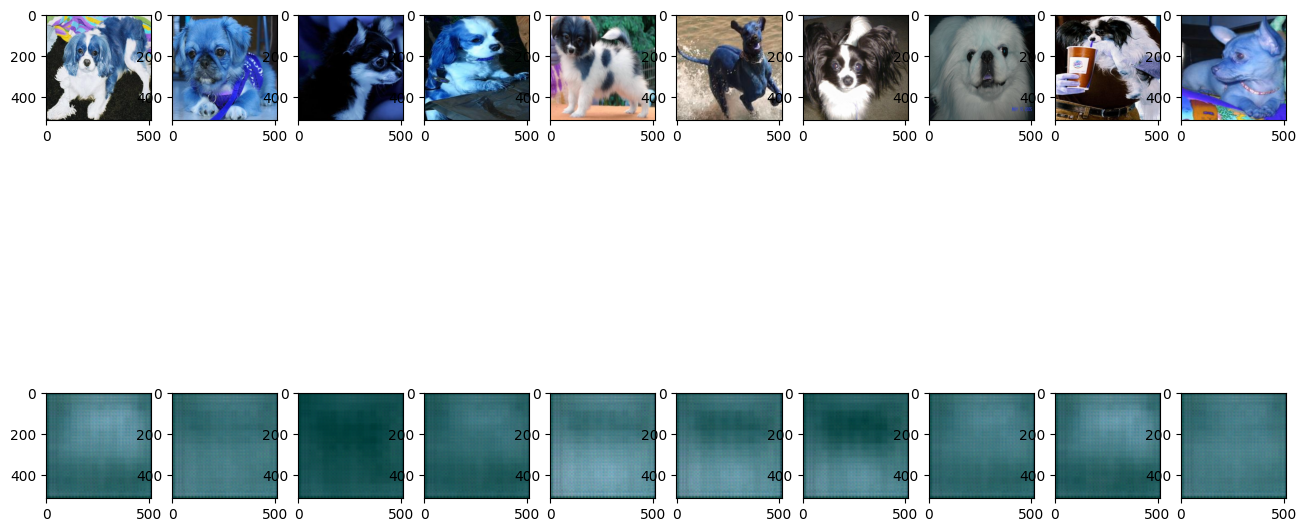

In [92]:
encoded_imgs = []
decoded_imgs = []

plt.rcParams["figure.figsize"] = [16, 9]
def compare_with_reconstructions(trainset, hashNet):
    fig, ax = plt.subplots(2, 10)

    random_imgs = random.sample(range(len(trainset)), 10)

    hashNet.train()
    for i, idx in enumerate(random_imgs):
        img = trainset[idx][0]
        img = img[None, :, :, :]
        img = img.to(device)
        decoded = hashNet(img)
        decoded = torch.squeeze(decoded)
        ax[0][i].imshow(trainset[idx][0].permute(1, 2, 0))
        ax[1][i].imshow(decoded.cpu().permute(1, 2, 0).detach().numpy())

    plt.show()

compare_with_reconstructions(trainset, hashNet)

In [93]:
myHash = ""
hsh_norm = torch.round(hsh.squeeze() * 62 + 48).to(torch.int32)
for i in range(encoding_size):
    let = hsh_norm[i] + 7*int(84 > hsh_norm[i] > 57) + 13*int(83 < hsh_norm[i])
    myHash += chr(let)

In [94]:
myHash

'{{{06{0{{{{{{{0{0{0{00{{0{0t{{{{00{{00{00K270{00000{{{{{1{{G{{{0'

## Model 2 (hash length: 512)

In [95]:
encoding_size=512
cl2 = Classifier(encoding_size=encoding_size, classes=10).to(device)
hshNet2 = HashingNet(encoding_size=encoding_size).to(device)

In [96]:
cl2_opt = torch.optim.Adam(cl2.parameters(), lr=0.001)
train_classifier(cl2, train_loader, cl2_opt, epochs=6)

100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


[1, 15] loss: 0.03480736470222473, accuracy: 0.175


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


[2, 15] loss: 0.03280044484138489, accuracy: 0.245


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


[3, 15] loss: 0.030073150396347045, accuracy: 0.37


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


[4, 15] loss: 0.028033403277397156, accuracy: 0.405


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


[5, 15] loss: 0.026910992980003358, accuracy: 0.42


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


[6, 15] loss: 0.02566501235961914, accuracy: 0.365


In [97]:
copy_weights_from_classifier(cl2, hshNet2)

In [98]:
hn2_opt = torch.optim.Adam(hshNet2.parameters(), lr=0.0005)
train_autoencoder(hshNet2, train_loader, hn2_opt, epochs=5)

100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


[1, 15] loss: 0.005590566337108612


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


[2, 15] loss: 0.004527814745903015


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


[3, 15] loss: 0.0036947978287935257


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


[4, 15] loss: 0.0032125096470117568


100%|██████████| 15/15 [00:34<00:00,  2.29s/it]

[5, 15] loss: 0.0030536417216062545


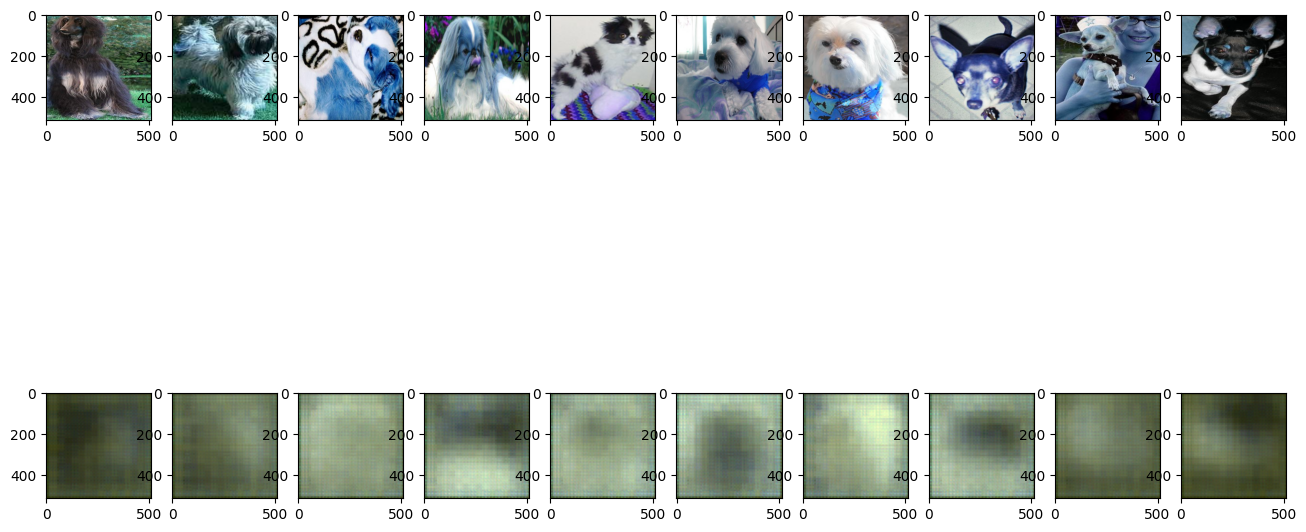

In [100]:
compare_with_reconstructions(trainset, hshNet2)

In [101]:
compare(hshNet2, trainset, 11, 12)

(True, tensor([0.8302], device='cuda:0', grad_fn=<SumBackward1>))

In [102]:
compare(hshNet2, trainset, 11, 200)

(False, tensor([0.8215], device='cuda:0', grad_fn=<SumBackward1>))